
# Dataset split train and test with timeseries generator

## Import libraries

In [1]:
!nvidia-smi

Wed Jan 12 10:11:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   34C    P0    34W / 300W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| N/A   39C    P0    38W / 300W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
#os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from decimal import Decimal
import numpy as np
import glob
import importlib
import gc
import matplotlib.pyplot as plt
#from livelossplot import PlotLossesKeras
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import gc # Garbage Collector
import pandas as pd
from numpy import savez_compressed
from joblib import dump, load
import h5py

from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, load_model
from keras.layers import LSTM, TimeDistributed, BatchNormalization
from keras.layers.core import Dense, Flatten, Dropout, RepeatVector, Reshape
from keras.layers.convolutional import Conv3D, Conv3DTranspose, MaxPooling3D 
from keras.callbacks import ModelCheckpoint

from platform import python_version
import keras
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # True dynamically grow the memory used on the GPU
sess = tf.compat.v1.Session(config=config)
set_session(sess)

from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print('Notebook running on Python', python_version())
print('Numpy version', np.version.version)
print('Scikit-learn version {}.'.format(sklearn.__version__))
print('Keras version ', keras.__version__,'and TensorFlow', tf.__version__, '(CUDA:', tf.test.is_built_with_cuda(), '- GPUs available:', get_available_gpus(), ')')

KeyboardInterrupt: 

## Define global variables
Such as object dimension and dataset properties

In [ ]:
dimX, dimY, dimZ = 117, 86, 38
n_cells = dimX * dimY * dimZ
dims = (dimX, dimY, dimZ)
n_channels = 1
n_input = 3
n_output = 10
n_batch = 8
leakyrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_datasets, batch_size=128, dim=(32,32,32), n_channels=3, shuffle=True, observation_samples=3, multistep=1):
        #print('Generator Initialization')
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.n_input = observation_samples      
        self.n_output = multistep
        self.last_samples = self.n_input - 1 + self.n_output      
        
        self.indexes = []
        cnt = 0
        self.total_samples = 0
        for case in list_datasets:
            samples = len(case) - self.last_samples
            self.total_samples += samples
            for sample in range(samples):
                self.indexes.append(cnt)
                cnt += 1
            cnt += self.last_samples
        
        self.ds = np.concatenate((list_datasets), axis = 0)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.total_samples / self.batch_size))
  
    def __getitem__(self, batch_index):          
        'Generate one batch of data through dataset'
        list_IDs_temp = self.indexes[batch_index * self.batch_size : (batch_index+1) * self.batch_size]
        #print(index, list_IDs_temp)
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        #print('Yieded batch %d' % index)
        return X, y

    def on_epoch_end(self):
        #'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels * self.n_input))
        y = np.empty((self.batch_size, *self.dim, self.n_channels * self.n_output))
        
        for i, ID in enumerate(list_IDs_temp):  
            inFrom = ID
            inTo = inFrom + self.n_input
            outFrom = inTo
            outTo = outFrom + self.n_output
            
            X[i] = np.concatenate((self.ds[inFrom : inTo]), axis = 3)
            y[i] = np.concatenate((self.ds[outFrom : outTo]), axis = 3)
        return X, y

In [ ]:
tsini=0
tsend=200
basepath = "/home/bsc21/bsc21334/SCRATCH/aina-data/"
pathnpz = basepath + "/NPZs/"
targetname = "/case3.5.npz"
#path = basepath + "/MODEL-%d-%d/" % (tsini, tsend)
path = basepath + "/MODCHAN%d-%d-%d/" % (n_output, tsini, tsend)
if not os.path.exists(path):
    os.mkdir(path)
datapath = basepath + "/DATAFULL-%d-%d/" % (tsini, tsend)
if not os.path.exists(datapath):
    os.mkdir(datapath)

## Load data from files
Data is filtered and reshaped for scaling.
First 200 samples are kept, while the rest of them are thirded.


In [ ]:
#%%time
with h5py.File(datapath + "train.h5","r") as hf:
    ds_ready = hf["dataset"][:]
#ds_ready = np.array(ds_ready, dtype=np.float16)

In [9]:
print('Dataset size in memory: %0.2f GB' % (ds_ready.nbytes / 1024**3))
np.info(ds_ready)

Dataset size in memory: 20.51 GB
class:  ndarray
shape:  (3, 24, 200, 117, 86, 38, 1)
strides:  (7341235200, 305884800, 1529424, 13072, 152, 4, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7ff71b480010
byteorder:  little
byteswap:  False
type: float32


## Define the ML model

In [11]:
n_epochs=1000
n_batch = 4
trainratio = -4

Epoch 1/1000
940/940 [==============================] - ETA: 0s - loss: 0.0565
Epoch 00001: val_loss improved from inf to 0.14833, saving model to /home/bsc21/bsc21334/SCRATCH/aina-data//MODCHAN10-0-200/weights0.hdf5
940/940 [==============================] - 448s 477ms/step - loss: 0.0565 - val_loss: 0.1483
Epoch 2/1000
940/940 [==============================] - ETA: 0s - loss: 0.1496
Epoch 00002: val_loss improved from 0.14833 to 0.02093, saving model to /home/bsc21/bsc21334/SCRATCH/aina-data//MODCHAN10-0-200/weights0.hdf5
940/940 [==============================] - 448s 476ms/step - loss: 0.1496 - val_loss: 0.0209
Epoch 3/1000
940/940 [==============================] - ETA: 0s - loss: 0.0234
Epoch 00003: val_loss improved from 0.02093 to 0.01893, saving model to /home/bsc21/bsc21334/SCRATCH/aina-data//MODCHAN10-0-200/weights0.hdf5
940/940 [==============================] - 449s 478ms/step - loss: 0.0234 - val_loss: 0.0189
Epoch 4/1000
940/940 [==============================] - ETA: 0

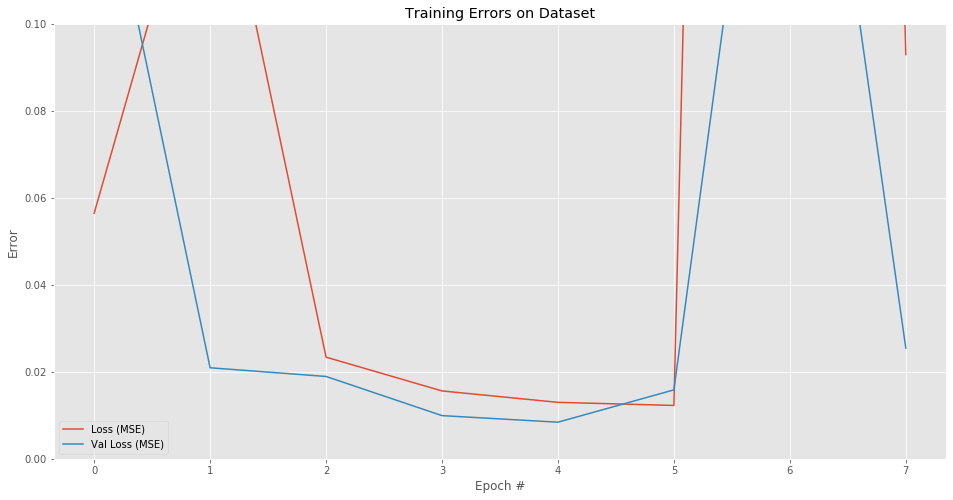

Epoch 1/1000
940/940 [==============================] - ETA: 0s - loss: 0.0650
Epoch 00001: val_loss improved from inf to 0.03929, saving model to /home/bsc21/bsc21334/SCRATCH/aina-data//MODCHAN10-0-200/weights1.hdf5
940/940 [==============================] - 454s 483ms/step - loss: 0.0650 - val_loss: 0.0393
Epoch 2/1000
940/940 [==============================] - ETA: 0s - loss: 0.0332
Epoch 00002: val_loss did not improve from 0.03929
940/940 [==============================] - 453s 482ms/step - loss: 0.0332 - val_loss: 0.1149
Epoch 3/1000
940/940 [==============================] - ETA: 0s - loss: 0.0212
Epoch 00003: val_loss improved from 0.03929 to 0.02061, saving model to /home/bsc21/bsc21334/SCRATCH/aina-data//MODCHAN10-0-200/weights1.hdf5
940/940 [==============================] - 454s 483ms/step - loss: 0.0212 - val_loss: 0.0206
Epoch 4/1000
940/940 [==============================] - ETA: 0s - loss: 0.0177
Epoch 00004: val_loss improved from 0.02061 to 0.01373, saving model to /h

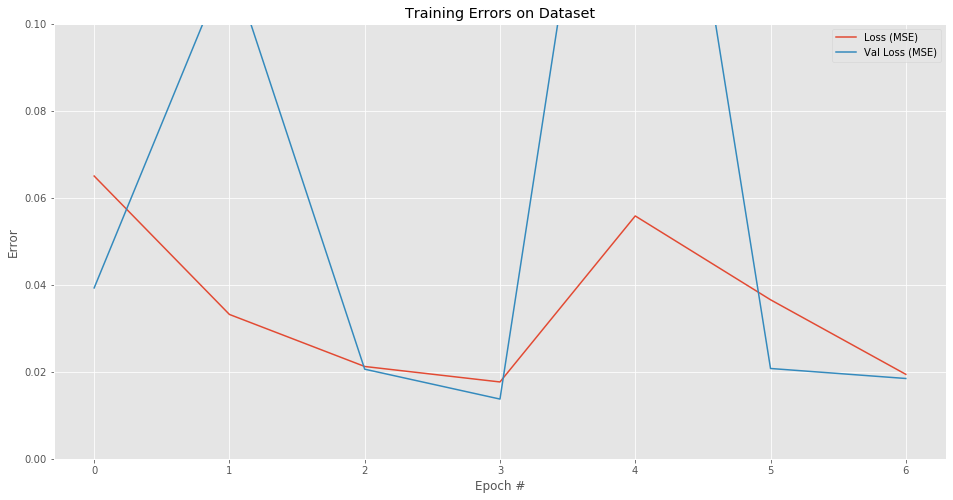

Epoch 1/1000
940/940 [==============================] - ETA: 0s - loss: 0.0370
Epoch 00001: val_loss improved from inf to 0.01456, saving model to /home/bsc21/bsc21334/SCRATCH/aina-data//MODCHAN10-0-200/weights2.hdf5
940/940 [==============================] - 454s 483ms/step - loss: 0.0370 - val_loss: 0.0146
Epoch 2/1000
940/940 [==============================] - ETA: 0s - loss: 0.0208
Epoch 00002: val_loss did not improve from 0.01456
940/940 [==============================] - 455s 484ms/step - loss: 0.0208 - val_loss: 0.0147
Epoch 3/1000
940/940 [==============================] - ETA: 0s - loss: 0.0139
Epoch 00003: val_loss improved from 0.01456 to 0.01202, saving model to /home/bsc21/bsc21334/SCRATCH/aina-data//MODCHAN10-0-200/weights2.hdf5
940/940 [==============================] - 453s 481ms/step - loss: 0.0139 - val_loss: 0.0120
Epoch 4/1000
940/940 [==============================] - ETA: 0s - loss: 0.1568
Epoch 00004: val_loss did not improve from 0.01202
940/940 [==============

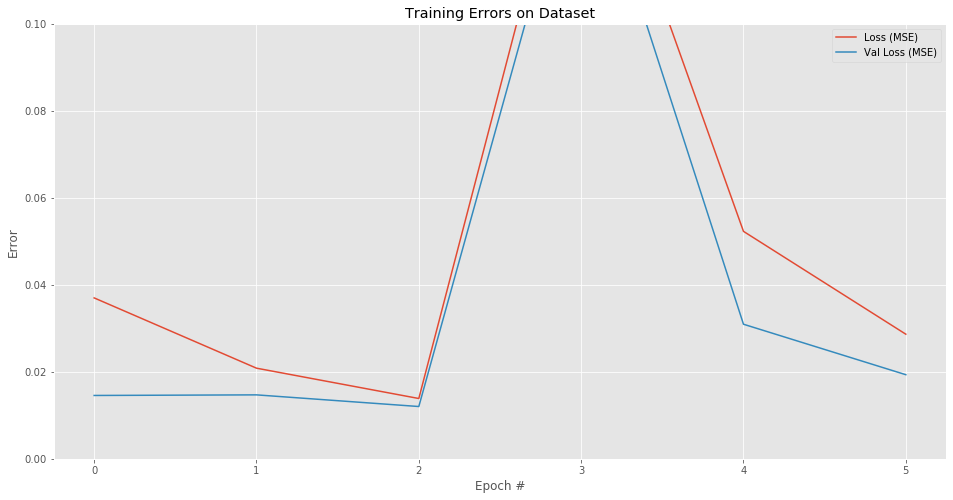

CPU times: user 2h 30min 23s, sys: 33min 57s, total: 3h 4min 21s
Wall time: 2h 38min 46s


In [14]:
%%time
for c in range(0,3):
    model = Sequential()
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation=leakyrelu, padding="same", data_format="channels_last", input_shape=(dimX, dimY, dimZ, n_input)))
    #model.add(Dropout(0.95))
    #model.add(Conv3D(64, kernel_size=(3, 3, 3), activation=leakyrelu, padding="same"))
    #model.add(Dropout(0.95))
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation=leakyrelu, padding="same"))
    #model.add(Dropout(0.95))
    #model.add(Conv3D(128, kernel_size=(3, 3, 3), activation=leakyrelu, padding="same"))
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation=leakyrelu, padding="same"))
    #model.add(Dropout(0.95))
    #model.add(Conv3D(32, kernel_size=(3, 3, 3), activation=leakyrelu, padding="same"))
    #model.add(Dropout(0.95))
    model.add(Dense(n_output))
    model.compile(loss='mse', optimizer='adam')#, metrics=[rmse, 'mae', 'mape'])
    model.save(path + "/model%d.hdf5" %  c)
    
    train = DataGenerator(ds_ready[c][:trainratio], 
    #train = DataGenerator(ds_ready[c], 
                      batch_size=n_batch, dim=dims, n_channels=n_channels, 
                      shuffle=True, observation_samples=n_input, multistep=n_output)
    validation = DataGenerator(ds_ready[c][trainratio:], 
                      batch_size=n_batch, dim=dims, n_channels=n_channels, 
                      shuffle=True, observation_samples=n_input, multistep=n_output)
    #print(len(train))
    #print(len(validation))

    checkpoint_file = path + "/weights%d.hdf5" % c
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001, verbose=1, restore_best_weights = True)
    checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_loss', verbose=1, save_best_only=True)
    callbacks_list = [checkpoint, earlystop]

    H = model.fit(train, validation_data=validation, epochs=n_epochs, verbose=1, shuffle=True, callbacks=callbacks_list)
    #H = model.fit(train, epochs=n_epochs, verbose=1, shuffle=True)#, callbacks=callbacks_list)
    print("End of channel", c)
    model.save_weights(checkpoint_file)
    
    hist = H.history
    plt.style.use("ggplot")
    plt.figure(figsize=(16,8))
    plt.plot(hist["loss"], label="Loss (MSE)")
    plt.plot(hist["val_loss"], label="Val Loss (MSE)")
    plt.title("Training Errors on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Error")
    plt.legend()
    plt.ylim(0,0.1)
    #plt.xlim(0,8)
    plt.savefig(path + "/plot%d.png" % c)
    plt.show()

In [ ]:
import os
os._exit(00)



## Load model

In [11]:
from keras.utils import plot_model
from IPython.display import Image 

c = 0

model = load_model(path + "model%d.hdf5" % c, custom_objects={'<lambda>': leakyrelu})
model.load_weights(path + "weights%d.hdf5" % c)

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 117, 86, 38, 64)   5248      
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 117, 86, 38, 128)  221312    
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 117, 86, 38, 64)   221248    
_________________________________________________________________
dense_3 (Dense)              (None, 117, 86, 38, 10)   650       
Total params: 448,458
Trainable params: 448,458
Non-trainable params: 0
_________________________________________________________________


In [6]:
with h5py.File(datapath + "test.h5","r") as hf:
    ds_ready = hf["dataset"][:]
print(ds_ready.shape)
#case35ds = ds_ready[:,0,:,:,:,:,:]
#print(case35ds.shape)

(3, 7, 200, 117, 86, 38, 1)


In [8]:
n_batch = 4
n_channels = 1

for c in range(0,3):
    model = load_model(path + "model%d.hdf5" % c, custom_objects={'<lambda>': leakyrelu})
    model.load_weights(path + "weights%d.hdf5" % c)
    test = DataGenerator(ds_ready[c][:], 
                      batch_size=n_batch, dim=dims, n_channels=n_channels, 
                      shuffle=False, observation_samples=n_input, multistep=n_output)
    model.evaluate(test, verbose=1)

329/329 [==============================] - 61s 184ms/step - loss: 0.0126


In [25]:
n_batch = 1
for c in range(0,3):
    print("Channel %d" % c)
    results = []
    ds_test = ds_ready[c][0]
    samples = n_input + n_output - 1
    for offset in range(len(ds_test) - samples):
        samples = n_input + offset + n_output + 1
        #print(offset, samples)
        test = DataGenerator(np.expand_dims(ds_test[offset : samples], axis=0), batch_size=n_batch, 
                            dim=dims, n_channels=n_channels, shuffle=False, observation_samples=n_input, 
                             multistep = n_output)
        results.append(model.evaluate(test, verbose=0))
        
    print("\t\tFrom %d samples: Min error: %.2E, Max error: %.2E, Mean error: %.2E, Std error: %.2E" % 
                                  (len(results), Decimal(float(np.min(results))), Decimal(float(np.max(results))), 
                                   Decimal(float(np.mean(results))), Decimal(float(np.std(results)))))

Channel 0
		From 188 samples: Min error: 8.56E-04, Max error: 7.53E-02, Mean error: 6.01E-03, Std error: 9.28E-03
Channel 1
		From 188 samples: Min error: 1.50E-03, Max error: 6.18E-02, Mean error: 1.12E-02, Std error: 1.41E-02
Channel 2
		From 188 samples: Min error: 1.78E-03, Max error: 1.23E-01, Mean error: 1.68E-02, Std error: 2.42E-02


In [32]:
n_batch = 1
for c in range(0,3):
    print("Channel %d" % c)
    mins = []
    maxs = []
    means = []
    stds = []
    for case in range(len(ds_ready[c])):
        print("\tCase %d" % case)
        results = []
        ds_test = ds_ready[c][case]
        samples = n_input + n_output - 1
        for offset in range(len(ds_test) - samples):
            samples = n_input + offset + n_output + 1
            #print(offset, samples)
            test = DataGenerator(np.expand_dims(ds_test[offset : samples], axis=0), batch_size=n_batch, 
                                dim=dims, n_channels=n_channels, shuffle=False, observation_samples=n_input, 
                                 multistep = n_output)
            results.append(model.evaluate(test, verbose=0))
        
        mins.append(Decimal(float(np.min(results))))
        maxs.append(Decimal(float(np.max(results))))
        means.append(Decimal(float(np.mean(results))))
        stds.append(Decimal(float(np.std(results))))
        print("\t\tFrom %d samples: Min error: %.2E, Max error: %.2E, Mean error: %.2E, Std error: %.2E" % 
                                      (len(results), mins[-1], maxs[-1], means[-1], stds[-1]))

    print("From %d cases: Min error: %.2E, Max error: %.2E, Mean error: %.2E, Std error: %.2E" % 
                                      (len(mins), Decimal(float(np.min(mins))), 
                                       Decimal(float(np.max(maxs))), 
                                       Decimal(float(np.mean(means))), 
                                       Decimal(float(np.std(stds)))))        

Channel 0
	Case 0
		From 188 samples: Min error: 8.56E-04, Max error: 7.53E-02, Mean error: 6.01E-03, Std error: 9.28E-03
	Case 1
		From 188 samples: Min error: 8.31E-04, Max error: 6.75E-02, Mean error: 6.21E-03, Std error: 9.50E-03
	Case 2
		From 188 samples: Min error: 9.41E-04, Max error: 1.03E-01, Mean error: 5.97E-03, Std error: 1.06E-02
	Case 3
		From 188 samples: Min error: 5.77E-03, Max error: 9.44E-02, Mean error: 1.07E-02, Std error: 9.41E-03
	Case 4
		From 188 samples: Min error: 8.31E-04, Max error: 6.75E-02, Mean error: 6.21E-03, Std error: 9.50E-03
	Case 5
		From 188 samples: Min error: 8.31E-04, Max error: 6.75E-02, Mean error: 6.21E-03, Std error: 9.50E-03
	Case 6
		From 188 samples: Min error: 9.41E-04, Max error: 1.03E-01, Mean error: 5.97E-03, Std error: 1.06E-02
From 7 cases: Min error: 8.31E-04, Max error: 1.03E-01, Mean error: 6.75E-03, Std error: 5.20E-04
Channel 1
	Case 0
		From 188 samples: Min error: 1.50E-03, Max error: 6.18E-02, Mean error: 1.12E-02, Std er

In [10]:
%%time
samples_per_case = []
ds = []
filename = pathnpz + targetname
print(filename)
ds = np.load(filename)
ds = np.array(ds.f.data[tsini:tsend])
print(ds.shape)
ds = ds.reshape(ds.shape[0] * ds.shape[1] * ds.shape[2] * ds.shape[3], ds.shape[4])

#ds= np.array(ds)
print(ds.shape)

/home/bsc21/bsc21334/SCRATCH/aina-data//NPZs//case3.5.npz
(200, 117, 86, 38, 3)
(76471200, 3)
CPU times: user 14.6 s, sys: 834 ms, total: 15.5 s
Wall time: 15.6 s


In [13]:
dsX = ds[:, 0]
dsX = dsX.reshape((-1, n_cells))
dsY = ds[:, 1]
dsY = dsY.reshape((-1, n_cells))
dsZ = ds[:, 2]
dsZ = dsZ.reshape((-1, n_cells))

In [14]:
scalerX = load(path + '/scalerX.joblib')
scalerY = load(path + '/scalerY.joblib')
scalerZ = load(path + '/scalerZ.joblib')

In [15]:
dsX = scalerX.transform(dsX)
dsX = dsX.reshape(-1, dimX, dimY, dimZ, 1)
dsY = scalerY.transform(dsY)
dsY = dsY.reshape(-1, dimX, dimY, dimZ, 1)
dsZ = scalerZ.transform(dsZ)
dsZ = dsZ.reshape(-1, dimX, dimY, dimZ, 1)

In [12]:
for c in range(0,3):
    model = load_model(path + "model%d.hdf5" % c, custom_objects={'<lambda>': leakyrelu})
    model.load_weights(path + "weights%d.hdf5" % c)

In [7]:
model = load_model(path + "model0.hdf5", custom_objects={'<lambda>': leakyrelu})
model.summary()
model.load_weights(path + "weights0.hdf5")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 117, 86, 38, 64)   5248      
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 117, 86, 38, 128)  221312    
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 117, 86, 38, 64)   221248    
_________________________________________________________________
dense_3 (Dense)              (None, 117, 86, 38, 10)   650       
Total params: 448,458
Trainable params: 448,458
Non-trainable params: 0
_________________________________________________________________


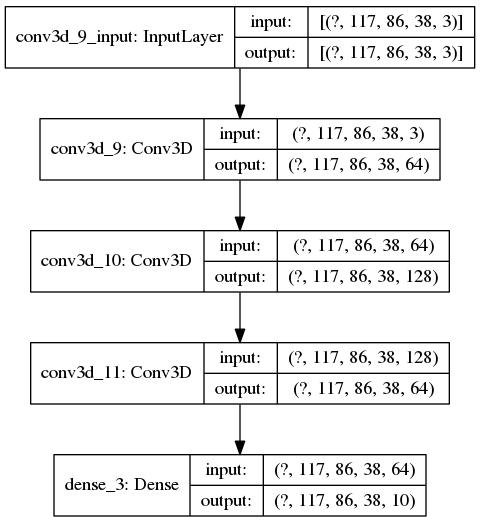

In [8]:
from keras.utils import plot_model
from IPython.display import Image 

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')

In [ ]:
dsX = ds[:, 0]
dsX = dsX.reshape((-1, n_cells))
dsY = ds[:, 1]
dsY = dsY.reshape((-1, n_cells))
dsZ = ds[:, 2]
dsZ = dsZ.reshape((-1, n_cells))

In [ ]:
#dsX = scalerX.transform(dsX)
dsX = dsX.reshape(-1, dimX, dimY, dimZ, 1)
#dsY = scalerY.transform(dsY)
dsY = dsY.reshape(-1, dimX, dimY, dimZ, 1)
#dsZ = scalerZ.transform(dsZ)
dsZ = dsZ.reshape(-1, dimX, dimY, dimZ, 1)

In [ ]:
ds_test = np.concatenate((dsX, dsY, dsZ), axis=4)
ds_test.shape

In [ ]:
with h5py.File(datapath + "test.h5", "w") as hf:
    hf.create_dataset("dataset",  data=ds_test)

In [ ]:
%%time
with h5py.File(datapath + "test.h5","r") as hf:
    ds_test = hf["dataset"][:]

## Evaluation

In [ ]:
%%time
n_batch = 1
results = []
samples = n_input + n_output - 1
for offset in range(len(ds_test) - samples):
    samples = n_input + offset + n_output + 1
    #print(offset, samples)
    test = DataGenerator(np.expand_dims(ds_test[offset : samples], axis=0), batch_size=n_batch, dim=dims, n_channels=n_channels, shuffle=False, observation_samples=n_input, multistep = n_output)
    results.append(model.evaluate(test, verbose=0))

In [ ]:
print("From %d samples: Min error: %.2E, Max error: %.2E, Mean error: %.2E, Std error: %.2E" % 
      (len(results), Decimal(float(np.min(results))), Decimal(float(np.max(results))), 
       Decimal(float(np.mean(results))), Decimal(float(np.std(results)))))

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(16,8))
plt.plot(results, label="MSE")
plt.title("Error per predicted timesteps")
plt.xlabel("Timestep")
plt.ylabel("Error")
plt.legend()
#plt.ylim(0,0.1)
plt.show()

## Prediction

In [ ]:
test = DataGenerator(np.expand_dims(ds_test, axis=0), batch_size=1, dim=dims, n_channels=n_channels, shuffle=False, observation_samples=n_input, multistep = n_output)
pred_output = model.predict(test, verbose=1)
pred_output = np.array(pred_output) #, dtype=np.float16)

## Inverse scaling of test and prediction dataset

In [ ]:
y_pred = pred_output.reshape(-1, n_output, dimX, dimY, dimZ, n_channels)
y_pred.shape

In [ ]:
y_test = []
#samples = n_input + n_output - 1
for offset in range(n_input, len(ds_test)-n_output+1):
    samples = offset + n_output
    y_test.append(ds_test[offset:samples])
y_test = np.array(y_test)
y_test.shape

In [ ]:
test_output = y_test
pred_output = y_pred
print(ds_test.shape)
print(test_output.shape)
print(pred_output.shape)

In [ ]:
mean_squared_error(test_output.reshape(-1,n_cells), pred_output.reshape(-1, n_cells))

In [ ]:
dsX_test = test_output[:,:,:,:,:,0].reshape(-1, n_cells)
scalerX.inverse_transform(dsX_test)
dsX_pred = pred_output[:,:,:,:,:,0].reshape(-1, n_cells)
scalerX.inverse_transform(dsX_pred)

dsY_test = test_output[:,:,:,:,:,1].reshape(-1, n_cells)
scalerY.inverse_transform(dsY_test)
dsY_pred = pred_output[:,:,:,:,:,1].reshape(-1, n_cells)
scalerY.inverse_transform(dsY_pred)

dsZ_test = test_output[:,:,:,:,:,2].reshape(-1, n_cells)
scalerZ.inverse_transform(dsZ_test)
dsZ_pred = pred_output[:,:,:,:,:,2].reshape(-1, n_cells)
scalerZ.inverse_transform(dsZ_pred)

print(dsX_test.shape)
print(dsX_pred.shape)

## Error calculation per timestep and channel

In [ ]:
%%time
print("Range test dataset X [%0.2f:%0.2f]" % (np.min(dsX_test), np.max(dsX_test)))
print("Range predicted dataset X [%0.2f:%0.2f]" % (np.min(dsX_pred), np.max(dsX_pred)))
#mse = mean_squared_error(dsX_test, dsX_pred)
#print("MSE: %.2E" % Decimal(float(mse)))
msesX = []
for ts in range(len(dsX_test)):
    tsX_test = dsX_test[ts]
    tsX_pred = dsX_pred[ts]
    #print(tsX_pred.shape)
    msesX.append(mean_squared_error(tsX_test, tsX_pred))
msesX = np.array(msesX)
#print(msesX.shape)
print("Min error: %.2E, Max error: %.2E, Mean error: %.2E, Std error: %.2E" % 
      (Decimal(float(np.min(msesX))), Decimal(float(np.max(msesX))), 
       Decimal(float(np.mean(msesX))), Decimal(float(np.std(msesX)))))

In [ ]:
%%time
print("Range test dataset Y [%0.2f:%0.2f]" % (np.min(dsY_test), np.max(dsY_test)))
print("Range predicted dataset Y [%0.2f:%0.2f]" % (np.min(dsY_pred), np.max(dsY_pred)))
#mse = mean_squared_error(dsY_test, dsY_pred)
#print("MSE: %.2E" % Decimal(float(mse)))
msesY = []
for ts in range(len(dsY_test)):
    tsY_test = dsY_test[ts]
    tsY_pred = dsY_pred[ts]
    msesY.append(mean_squared_error(tsY_test, tsY_pred))
msesY = np.array(msesY)
print("Min error: %.2E, Max error: %.2E, Mean error: %.2E, Std error: %.2E" % 
      (Decimal(float(np.min(msesY))), Decimal(float(np.max(msesY))), 
       Decimal(float(np.mean(msesY))), Decimal(float(np.std(msesY)))))

In [ ]:
%time
print("Range test dataset Z [%0.2f:%0.2f]" % (np.min(dsZ_test), np.max(dsZ_test)))
print("Range predicted dataset Z [%0.2f:%0.2f]" % (np.min(dsZ_pred), np.max(dsZ_pred)))
#mse = mean_squared_error(dsZ_test, dsZ_pred)
#print("MSE: %.2E" % Decimal(float(mse)))
msesZ = []
for ts in range(len(dsZ_test)):
    tsZ_test = dsZ_test[ts]
    tsZ_pred = dsZ_pred[ts]
    msesZ.append(mean_squared_error(tsZ_test, tsZ_pred))
msesZ = np.array(msesZ)
print("Min error: %.2E, Max error: %.2E, Mean error: %.2E, Std error: %.2E" % 
      (Decimal(float(np.min(msesZ))), Decimal(float(np.max(msesZ))), 
       Decimal(float(np.mean(msesZ))), Decimal(float(np.std(msesZ)))))

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(16,8))
plt.plot(msesX, label="X")
plt.plot(msesY, label="Y")
plt.plot(msesZ, label="Z")
plt.title("Error per predicted timesteps and channel")
plt.xlabel("Timestep")
plt.ylabel("MSE")
plt.legend()
#plt.ylim(0,0.01)
#plt.xlim(0,200)
plt.show()

In [ ]:
output_file = datapath + "/prediction"
data = pred_output[90]
print("Saving file: %s.npz, with shape:" % (output_file), data.shape)
savez_compressed(output_file, data=data, header=None)

In [ ]:
import os
os._exit(00)